In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#from __future__ import division
import pandas as pd
import numpy as np
from ggplot import *

import os
import sys

utils_path = os.path.abspath(os.path.join('..'))
if utils_path not in sys.path:
    sys.path.append(utils_path)
    
from utils.rpos import *


In [3]:
# Sample titles with corresponding barcodes
samples = {
    's9': ['ATCACG', 'ACAGTG'],
    's9+bcm': ['CGATGT', 'GCCAAT'],
    's17': ['TTAGGC', 'GATCAG'],
    's17+bcm': ['TGACCA', 'TAGCTT'],
    's19': ['CAGATC','GGCTAC'],
    's19+bcm': ['ACTTGA', 'CTTGTA']
}

# Barcodes
barcodes = ['ATCACG', 'ACAGTG', 'CGATGT', 'GCCAAT', 'TTAGGC', 'GATCAG',
            'TGACCA', 'TAGCTT', 'CAGATC','GGCTAC', 'ACTTGA', 'CTTGTA']

In [4]:
def get_counts_df(barcodes, res_dir='../results'):
    '''
    Aggregates htseq-count results into raw counts dataframe.
    Iterates over files whose name ends with '.counts' in `res_dir` and contains barcodes
    specified in `barcodes`.
    
    Builds a dataframe containing gene names and counts for the gene for every barcode.
    '''
    df = pd.DataFrame()
    d, _, filenames = next(os.walk(res_dir))
    infiles = [f for f in filenames if f.endswith('.counts')]
    for barcode in barcodes:
        cntfile = os.path.join(d, [f for f in infiles if barcode in f][0])
        df_ = pd.read_csv(cntfile, sep='\t', header=None, names=['gene','counts'])
        if df.empty:
            df['gene'] = df_['gene']
        df[barcode] = df_['counts']
    return df[~df['gene'].str.startswith('__')]

def get_utr_counts_df(df, barcodes, res_dir='../results'):
    '''
    Calculates 5'UTR coverage
    Iterates over files whose name ends with '_sorted.bam' in `res_dir` and contains barcodes
    specified in `barcodes`.
    
    Adds `utr_<barcode>` column to df DataFrame
    '''
    d, _, filenames = next(os.walk(res_dir))
    infiles = [f for f in filenames if f.endswith('_sorted.bam')]
    for barcode in barcodes:
        bamfile = os.path.join(d, [f for f in infiles if barcode in f][0])
        #df['utr_{0}'.format(barcode)] = get_coverage(df, bamfile, 'gi|556503834|ref|NC_000913.3|',
        #                                             key5='coord_5', key3='coord_3')
        df['utr_{0}'.format(barcode)] = get_counts(df, bamfile, 'gi|556503834|ref|NC_000913.3|',
                                                     key5='start', key3='end')
        

In [6]:
# htseq counts for genes (orfs)
count_df = get_counts_df(barcodes, res_dir='../../results')

# 5' UTR annotations
res = []
with open('../../results/redux/utrs_corr.bed', 'r') as fi:
    for line in fi:
        fields = line.strip().split()
        res.append({
                'gene': fields[3],
                'start': int(fields[1]),
                'end': int(fields[2]),
            })
 
df_utr5 = pd.DataFrame.from_records(res)
#df_utr5 = get_utr5_df('../../ref/UTR_map-seq-coords.txt')
df_utr5['UTR_length'] = abs(df_utr5['end'] - df_utr5['start'])
df_utr5 = df_utr5[df_utr5['UTR_length'] > 80]

# Merge the two on gene column
dfm = df_utr5.copy()
dfm = dfm.merge(count_df, on='gene')

# Count UTR hits and add them to the dataframe
get_utr_counts_df(dfm, barcodes, res_dir='../../results')

In [7]:
dfm

,end,gene,start,UTR_length,ATCACG,ACAGTG,CGATGT,GCCAAT,TTAGGC,GATCAG,...,utr_CGATGT,utr_GCCAAT,utr_TTAGGC,utr_GATCAG,utr_TGACCA,utr_TAGCTT,utr_CAGATC,utr_GGCTAC,utr_ACTTGA,utr_CTTGTA
0,5234,yaaX,5030,204,258,281,512,481,178,328,...,351.0,370.0,298.0,448.0,439.0,446.0,137.0,235.0,479.0,450.0
1,6587,yaaA,6459,128,885,819,688,768,677,1142,...,163.0,225.0,175.0,315.0,181.0,281.0,206.0,114.0,388.0,305.0
2,6615,yaaA,6459,156,885,819,688,768,677,1142,...,172.0,236.0,175.0,322.0,191.0,303.0,207.0,116.0,411.0,329.0
3,11542,yaaW,11356,186,36,63,1512,1942,36,74,...,504.0,776.0,12.0,36.0,567.0,1056.0,12.0,24.0,1505.0,1546.0
4,11913,yaaI,11786,127,24,40,581,926,31,51,...,304.0,356.0,14.0,23.0,389.0,399.0,8.0,13.0,458.0,440.0
5,11938,yaaI,11786,152,24,40,581,926,31,51,...,340.0,419.0,14.0,24.0,438.0,510.0,8.0,15.0,565.0,528.0
6,12163,dnaK,12048,115,36348,53503,62444,70306,39515,48358,...,2977.0,6584.0,4799.0,2830.0,6350.0,6968.0,2336.0,6099.0,15976.0,14174.0
7,17489,nhaA,17317,172,1646,1086,2994,3830,826,1366,...,792.0,1358.0,133.0,215.0,1301.0,1908.0,74.0,137.0,2949.0,2223.0
8,21210,rpsT,21078,132,67237,50862,25383,18595,27532,62067,...,9302.0,8966.0,14726.0,24465.0,10912.0,9380.0,23735.0,17554.0,7045.0,5706.0
9,22391,ileS,21833,558,20377,16745,9326,10862,15253,19726,...,1739.0,2728.0,5454.0,5556.0,2509.0,3155.0,4785.0,5718.0,6382.0,5578.0


In [8]:
dfm.to_csv('../../results/redux/dfm_raw.csv', sep='\t')

In [42]:
#id_vars = ['TSS','TU_name','coord_5','coord_3','gene', 'UTR_length']
id_vars = ['gene', 'UTR_length']
value_vars = ['s9','s17','s19','s9+bcm','s17+bcm','s19+bcm']

dfn = dfm.copy()

def pseudo_counts(x):
    return x + 1 if x == 0 else x

# Normalize counts by gene and utr length
def norm_orf(barcode, rec):
    #return float(rec[barcode] / abs(rec['first_gene_5'] - rec['first_gene_3']))
    return rec[barcode]

def norm_utr(barcode, rec):
    return float(rec['utr_{0}'.format(barcode)] / rec['UTR_length'])

for barcode in barcodes:
    dfn[barcode] = dfn[barcode].apply(pseudo_counts)
    dfn['orf_{0}'.format(barcode)] = dfn.apply(lambda rec: norm_orf(barcode, rec), axis=1)
    dfn['utr_{0}'.format(barcode)] = dfn.apply(lambda rec: norm_utr(barcode, rec), axis=1)

    
df = dfn[id_vars].copy()
# Take means across replicates according to the samples dict
for sample, bcs in samples.items():
    df['orf_{0}'.format(sample)] = np.log10(dfn[['orf_{0}'.format(b) for b in list(bcs)]].mean(axis=1))
    df['utr_{0}'.format(sample)] = np.log10(dfn[['utr_{0}'.format(b) for b in list(bcs)]].mean(axis=1))
df

,gene,UTR_length,orf_s17+bcm,utr_s17+bcm,orf_s9+bcm,utr_s9+bcm,orf_s19,utr_s19,orf_s17,utr_s17,orf_s9,utr_s9,orf_s19+bcm,utr_s19+bcm
0,yaaX,204,2.708846,0.336283,2.695919,0.247275,2.347330,-0.040117,2.403121,0.262079,2.430559,0.278642,2.886491,0.357356
1,yaaA,128,2.938269,0.256402,2.862131,0.180592,2.883945,0.096910,2.958803,0.281956,2.930440,0.236199,3.122380,0.432493
2,yaaA,156,2.938269,0.199572,2.862131,0.116506,2.883945,0.015048,2.958803,0.202202,2.930440,0.161944,3.122380,0.375077
3,yaaW,186,3.303952,0.639776,3.237292,0.536667,1.778151,-1.014240,1.740363,-0.889302,1.694605,-1.052029,3.678427,0.913899
4,yaaI,127,2.975891,0.491693,2.877083,0.414710,1.380211,-1.082614,1.612784,-0.836632,1.505150,-0.913472,3.217747,0.548443
5,yaaI,152,2.975891,0.493935,2.877083,0.397368,1.380211,-1.121146,1.612784,-0.903090,1.505150,-0.926571,3.217747,0.555747
6,dnaK,115,4.921624,1.762711,4.822005,1.618775,4.925830,1.564357,4.642825,1.520740,4.652493,1.332965,5.249165,2.117559
7,nhaA,172,3.623818,0.969811,3.533009,0.795880,3.015360,-0.212276,3.039811,0.005021,3.135451,-0.024675,4.024998,1.177100
8,rpsT,132,4.374583,1.885721,4.342205,1.840087,4.684401,2.194230,4.651273,2.171582,4.771216,2.320020,4.075273,1.683940
9,ileS,558,4.047664,0.705459,4.004063,0.602352,4.399579,0.973649,4.242777,0.994123,4.268601,0.927446,4.382755,1.030067


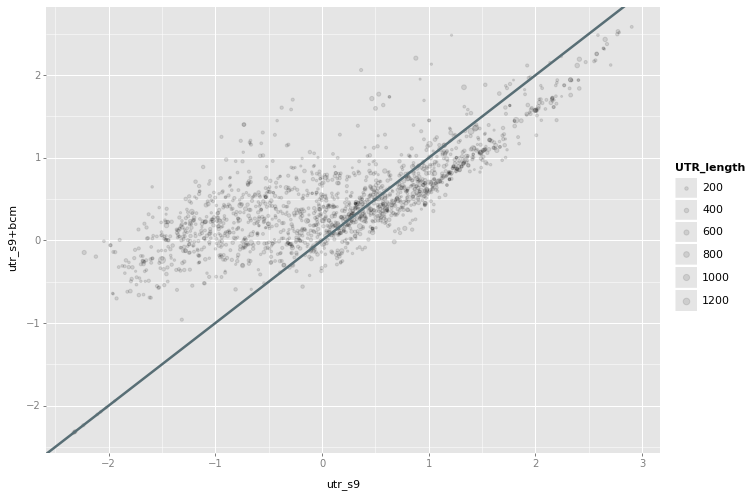

<ggplot: (8783559005255)>


In [43]:
p = ggplot(df, aes(x='utr_s9', y='utr_s9+bcm', size='UTR_length')) \
        + geom_point(alpha=0.1) \
        + geom_abline(slope=1, intercept=0, size=2.5, color='#586e75')
print(p)

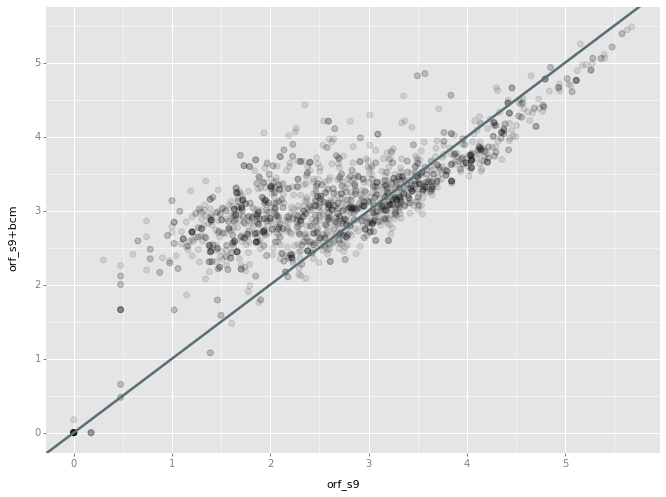

<ggplot: (-9223363253305905997)>


In [44]:
p = ggplot(df, aes(x='orf_s9', y='orf_s9+bcm')) \
        + geom_point(alpha=0.1) \
        + geom_abline(slope=1, intercept=0, size=2.5, color='#586e75')
print(p)

/home/ilya/.venv/pydata/lib/python3.4/site-packages/sklearn/neighbors/graph.py:36: DeprecationWarning: The behavior of 'kneighbors_graph' when mode='connectivity' will change in version 0.18. Presently, the nearest neighbor of each sample is the sample itself. Beginning in version 0.18, the default behavior will be to exclude each sample from being its own nearest neighbor. To maintain the current behavior, set include_self=True.
  "behavior, set include_self=True.", DeprecationWarning)
/home/ilya/.venv/pydata/lib/python3.4/site-packages/sklearn/cluster/k_means_.py:1252: DeprecationWarning: This function is deprecated. Please call randint(0, 1686 + 1) instead
  0, n_samples - 1, init_size)
/home/ilya/.venv/pydata/lib/python3.4/site-packages/sklearn/cluster/k_means_.py:593: DeprecationWarning: This function is deprecated. Please call randint(0, 1686 + 1) instead
  0, n_samples - 1, init_size)
/home/ilya/.venv/pydata/lib/python3.4/site-packages/sklearn/cluster/k_means_.py:593: Deprecatio

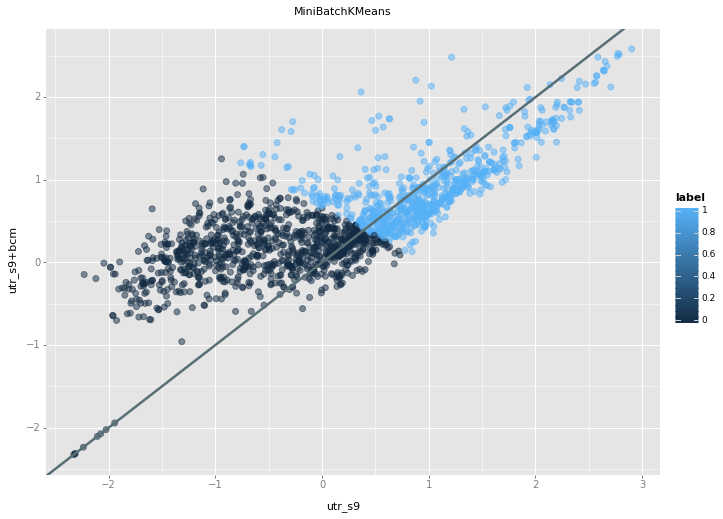

<ggplot: (-9223363253352715057)>


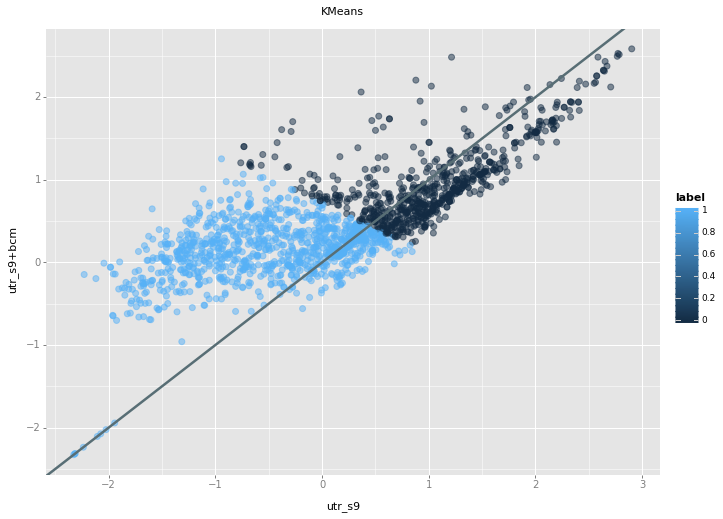

<ggplot: (8783583147219)>


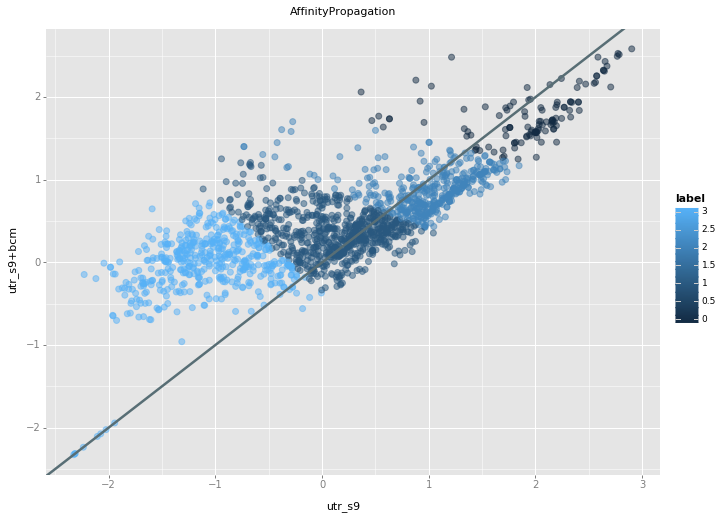

<ggplot: (8783577909645)>


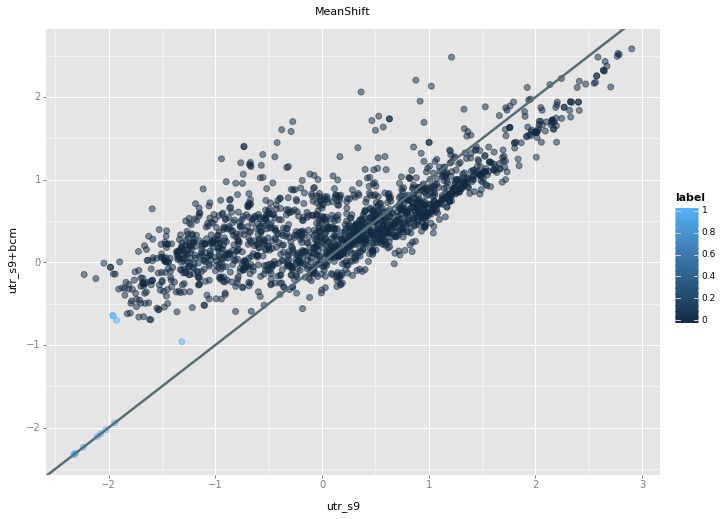

<ggplot: (-9223363253282665065)>


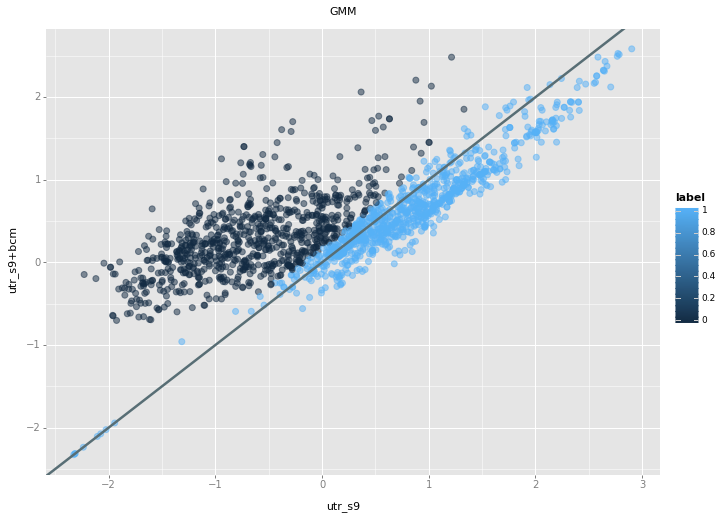

<ggplot: (8783569536618)>


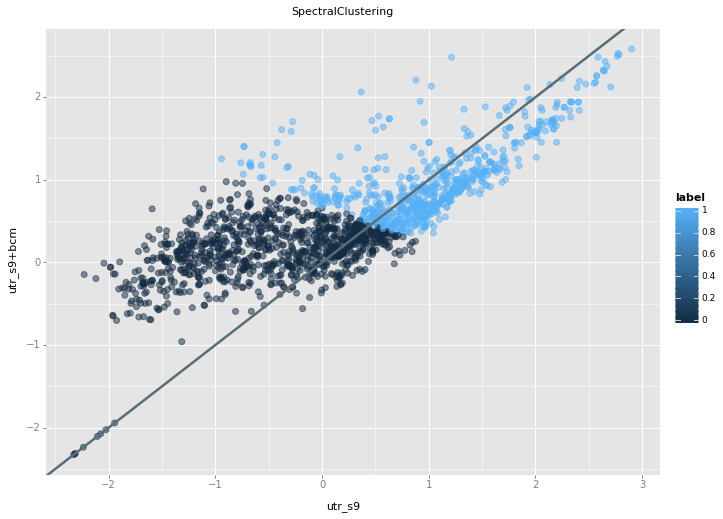

<ggplot: (-9223363253285253979)>


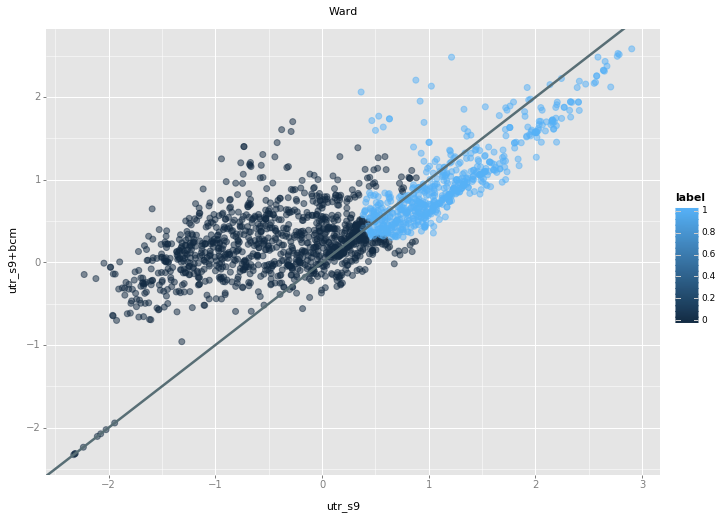

<ggplot: (8783566966683)>


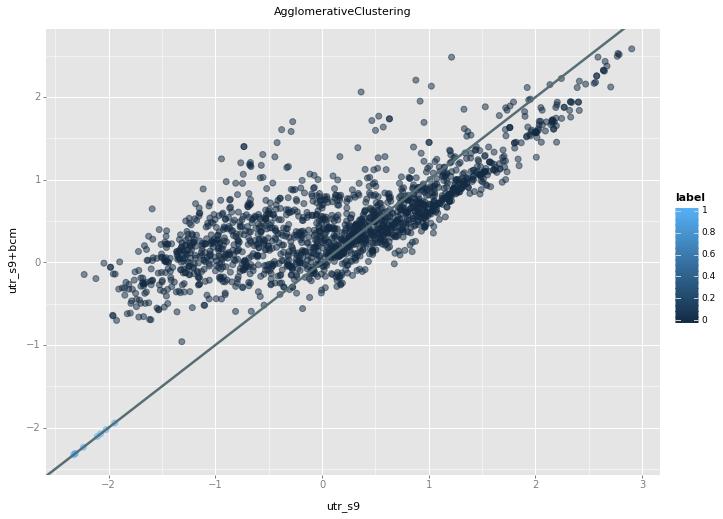

<ggplot: (8783566966690)>


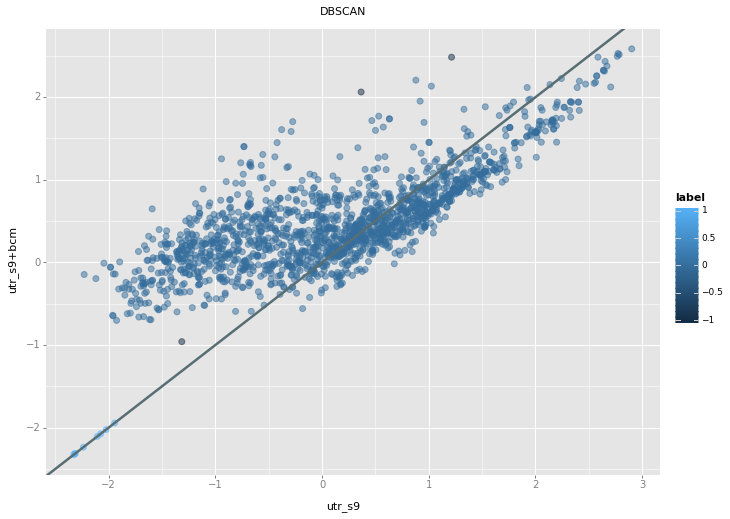

<ggplot: (8783583156032)>


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn import cluster
from sklearn import mixture

X = df.as_matrix(columns=['utr_s9', 'utr_s9+bcm'])
X = StandardScaler().fit_transform(X)

bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)
connectivity = kneighbors_graph(X, n_neighbors=20)
connectivity = 0.05 * (connectivity + connectivity.T)
#distances = euclidean_distances(X)

gmm = mixture.GMM(n_components=2, covariance_type='full')

ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=2, batch_size=200)
kmeans = cluster.KMeans(n_clusters=2)
ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward', connectivity=connectivity)
spectral = cluster.SpectralClustering(n_clusters=2, n_neighbors=20, eigen_solver='arpack', affinity='nearest_neighbors')
dbscan = cluster.DBSCAN(eps=.5)
affinity_propagation = cluster.AffinityPropagation(damping=.95, preference=-200)
average_linkage = cluster.AgglomerativeClustering(linkage='average', affinity='cityblock', n_clusters=2, connectivity=connectivity)

for name, alg in [
                    ('MiniBatchKMeans', two_means),
                    ('KMeans', kmeans),
                    ('AffinityPropagation', affinity_propagation),
                    ('MeanShift', ms),
                    ('GMM', gmm),
                    ('SpectralClustering', spectral),
                    ('Ward', ward),
                    ('AgglomerativeClustering', average_linkage),
                    ('DBSCAN', dbscan)
                ]:
    alg.fit(X)
    if hasattr(alg, 'labels_'):
        df['label'] = alg.labels_.astype(np.int)
    else:
        df['label'] = alg.predict(X)
    
    p = ggplot(df, aes(x='utr_s9', y='utr_s9+bcm', color='label')) \
        + geom_point(alpha=0.5) \
        + ggtitle(name) \
        + geom_abline(slope=1, intercept=0, size=2.5, color='#586e75')
    print(p)

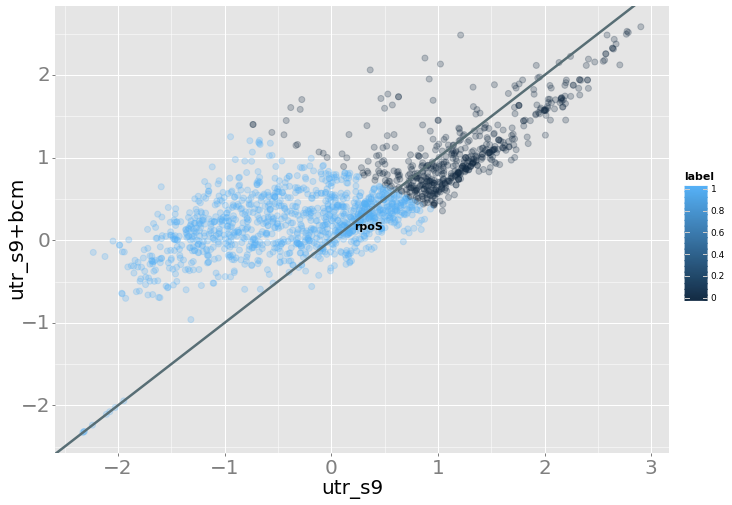

<ggplot: (-9223363253305990319)>


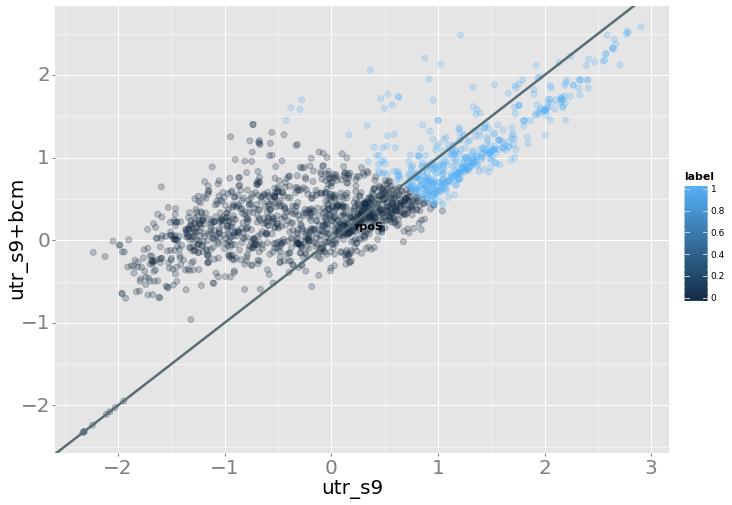

<ggplot: (-9223363253305931674)>


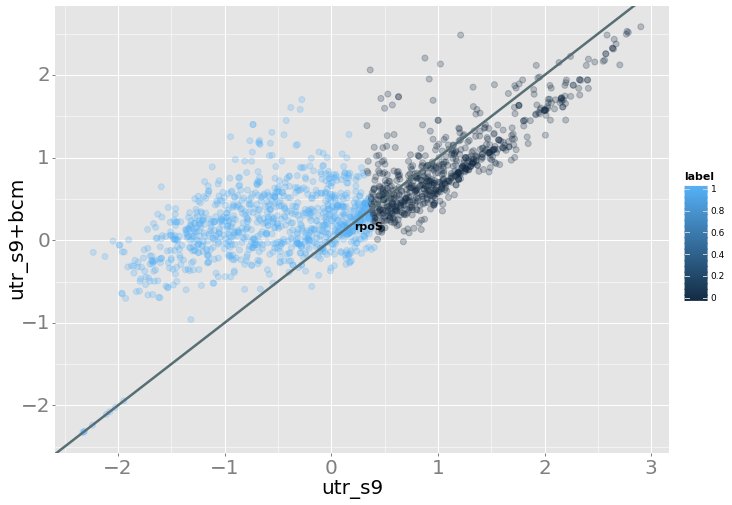

<ggplot: (-9223363253310980629)>


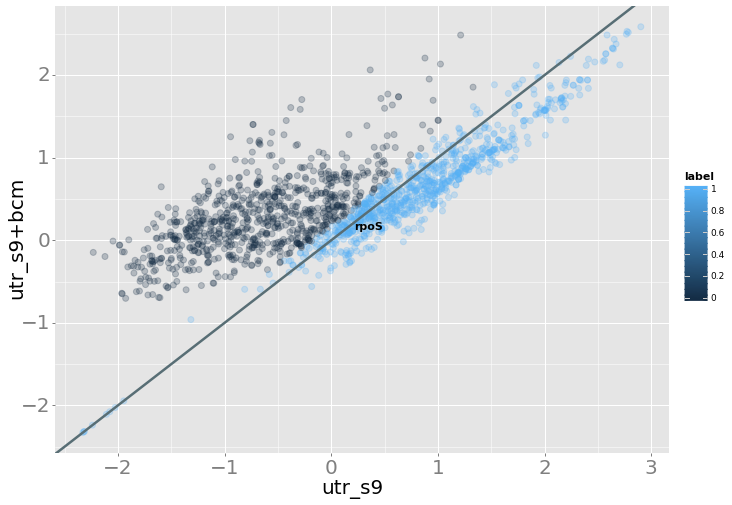

<ggplot: (-9223363253310931638)>


In [45]:
X = df.as_matrix(columns=['utr_s9', 'utr_s9+bcm'])
X = StandardScaler().fit_transform(X)
covar_type = ['spherical', 'diag', 'tied', 'full']

def rho_size(rec):
    if rec['gene'] == 'rpoS' and rec['UTR_length'] > 500:
        return 'rpoS'
    else:
        return ''
        

for covar in covar_type:
    gmm = mixture.GMM(n_components=2, covariance_type=covar)
    gmm.fit(X)
    df['label'] = gmm.predict(X)
    df['rho'] = df.apply(rho_size, axis=1)
    
    p = ggplot(df, aes(x='utr_s9', y='utr_s9+bcm', color='label', label='rho')) \
        + geom_point(alpha=0.24, size=5) \
        + geom_text(color="black") \
        + geom_abline(slope=1, intercept=0, size=2.5, color='#586e75') \
        + scale_x_continuous(name="-BCM (log(RPKM)") \
        + scale_y_continuous(name="+BCM (log(RPKM)") \
        + theme(axis_title=element_text(size=20),
                axis_text=element_text(size=20))
    print(p)

In [46]:
df

,gene,UTR_length,orf_s17+bcm,utr_s17+bcm,orf_s9+bcm,utr_s9+bcm,orf_s19,utr_s19,orf_s17,utr_s17,orf_s9,utr_s9,orf_s19+bcm,utr_s19+bcm,label,rho
0,yaaX,204,2.708846,0.336283,2.695919,0.247275,2.347330,-0.040117,2.403121,0.262079,2.430559,0.278642,2.886491,0.357356,1,
1,yaaA,128,2.938269,0.256402,2.862131,0.180592,2.883945,0.096910,2.958803,0.281956,2.930440,0.236199,3.122380,0.432493,1,
2,yaaA,156,2.938269,0.199572,2.862131,0.116506,2.883945,0.015048,2.958803,0.202202,2.930440,0.161944,3.122380,0.375077,1,
3,yaaW,186,3.303952,0.639776,3.237292,0.536667,1.778151,-1.014240,1.740363,-0.889302,1.694605,-1.052029,3.678427,0.913899,0,
4,yaaI,127,2.975891,0.491693,2.877083,0.414710,1.380211,-1.082614,1.612784,-0.836632,1.505150,-0.913472,3.217747,0.548443,0,
5,yaaI,152,2.975891,0.493935,2.877083,0.397368,1.380211,-1.121146,1.612784,-0.903090,1.505150,-0.926571,3.217747,0.555747,0,
6,dnaK,115,4.921624,1.762711,4.822005,1.618775,4.925830,1.564357,4.642825,1.520740,4.652493,1.332965,5.249165,2.117559,1,
7,nhaA,172,3.623818,0.969811,3.533009,0.795880,3.015360,-0.212276,3.039811,0.005021,3.135451,-0.024675,4.024998,1.177100,0,
8,rpsT,132,4.374583,1.885721,4.342205,1.840087,4.684401,2.194230,4.651273,2.171582,4.771216,2.320020,4.075273,1.683940,1,
9,ileS,558,4.047664,0.705459,4.004063,0.602352,4.399579,0.973649,4.242777,0.994123,4.268601,0.927446,4.382755,1.030067,1,


In [48]:
df[df['gene'] == 'alaC'][['utr_s9','utr_s9+bcm', 'label']]

,utr_s9,utr_s9+bcm,label
868,0.124416,0.314394,0


In [49]:
df.to_csv('../../results/redux/utr_bcm.csv', sep='\t')

In [25]:
X = df.as_matrix(columns=['utr_s9', 'utr_s9+bcm'])
#X = StandardScaler().fit_transform(X)

gmm = mixture.GMM(n_components=2, covariance_type='full')
gmm.fit(X)
df['label'] = gmm.predict(X)
df

,gene,UTR_length,orf_s17+bcm,utr_s17+bcm,orf_s9+bcm,utr_s9+bcm,orf_s19,utr_s19,orf_s17,utr_s17,orf_s9,utr_s9,orf_s19+bcm,utr_s19+bcm,label
0,yaaX,204,2.708846,0.336283,2.695919,0.247275,2.347330,-0.040117,2.403121,0.262079,2.430559,0.278642,2.886491,0.357356,1
1,yaaA,128,2.938269,0.256402,2.862131,0.180592,2.883945,0.096910,2.958803,0.281956,2.930440,0.236199,3.122380,0.432493,1
2,yaaA,156,2.938269,0.199572,2.862131,0.116506,2.883945,0.015048,2.958803,0.202202,2.930440,0.161944,3.122380,0.375077,1
3,yaaW,186,3.303952,0.639776,3.237292,0.536667,1.778151,-1.014240,1.740363,-0.889302,1.694605,-1.052029,3.678427,0.913899,0
4,yaaI,127,2.975891,0.491693,2.877083,0.414710,1.380211,-1.082614,1.612784,-0.836632,1.505150,-0.913472,3.217747,0.548443,0
5,yaaI,152,2.975891,0.493935,2.877083,0.397368,1.380211,-1.121146,1.612784,-0.903090,1.505150,-0.926571,3.217747,0.555747,0
6,dnaK,115,4.921624,1.762711,4.822005,1.618775,4.925830,1.564357,4.642825,1.520740,4.652493,1.332965,5.249165,2.117559,1
7,nhaA,172,3.623818,0.969811,3.533009,0.795880,3.015360,-0.212276,3.039811,0.005021,3.135451,-0.024675,4.024998,1.177100,0
8,rpsT,132,4.374583,1.885721,4.342205,1.840087,4.684401,2.194230,4.651273,2.171582,4.771216,2.320020,4.075273,1.683940,1
9,ileS,558,4.047664,0.705459,4.004063,0.602352,4.399579,0.973649,4.242777,0.994123,4.268601,0.927446,4.382755,1.030067,1


In [59]:
df[df['gene'] == 'rpoS'][['utr_s9', 'utr_s9+bcm', 'label']]

,utr_s9,utr_s9+bcm,label
985,0.454030,0.360994,1
986,0.397940,0.306022,1
987,0.353966,0.172502,1


In [27]:
df.to_csv('../../results/redux/utr_bcm.csv', sep='\t')

In [57]:
df[(df['label'] == 1) & (df['utr_s9'] < df['utr_s9+bcm'])]

,gene,UTR_length,orf_s17+bcm,utr_s17+bcm,orf_s9+bcm,utr_s9+bcm,orf_s19,utr_s19,orf_s17,utr_s17,orf_s9,utr_s9,orf_s19+bcm,utr_s19+bcm,label,rho
6,dnaK,115,4.921624,1.762711,4.822005,1.618775,4.925830,1.564357,4.642825,1.520740,4.652493,1.332965,5.249165,2.117559,1,
14,carA,100,3.066512,0.122216,3.012204,-0.026872,2.939769,-0.019997,2.683047,-0.207608,2.790637,-0.055517,3.277036,0.320146,1,
28,leuD,141,2.470557,-0.209700,2.419129,-0.248852,2.235528,-0.259917,2.105510,-0.459023,2.209515,-0.378367,2.764550,0.153977,1,
82,yafK,188,3.426674,0.647529,3.325310,0.552241,3.316704,0.449298,3.274620,0.471307,3.284769,0.519283,3.613419,0.794584,1,
86,proB,172,3.563422,0.723513,3.508866,0.640978,3.440594,0.295950,3.470190,0.485044,3.476687,0.551932,3.721316,0.859292,1,
87,proB,85,3.563422,0.983865,3.508866,0.905955,3.440594,0.601421,3.470190,0.790327,3.476687,0.855198,3.721316,1.121927,1,
118,yahM,152,3.052694,1.153514,2.923503,1.028876,1.897627,0.596669,2.341435,0.930929,2.062582,0.812913,3.133539,1.092430,1,
168,ybaB,367,3.483516,0.846280,3.408325,0.893291,3.492551,0.869184,3.346451,0.771093,3.329296,0.847458,3.512951,0.858744,1,
169,htpG,303,4.694824,1.356020,4.623596,1.302032,4.552984,1.242751,4.307785,1.209196,4.315404,1.206265,5.011251,1.478862,1,
173,ybaP,182,3.088136,0.462151,3.010724,0.280883,2.678973,0.143049,2.791691,0.514810,2.629410,0.175295,3.493458,0.703716,1,


In [63]:
# Sample titles with corresponding barcodes
samples = {
    's9': ['ATCACG', 'ACAGTG'],
    's9+bcm': ['CGATGT', 'GCCAAT'],
    's17': ['TTAGGC', 'GATCAG'],
    's17+bcm': ['TGACCA', 'TAGCTT'],
    's19': ['CAGATC','GGCTAC'],
    's19+bcm': ['ACTTGA', 'CTTGTA']
}

dfm[dfm['gene'] == 'rpoS'][['gene', 'UTR_length', 'utr_ATCACG', 'utr_ACAGTG', 'utr_CGATGT', 'utr_GCCAAT']]

,gene,UTR_length,utr_ATCACG,utr_ACAGTG,utr_CGATGT,utr_GCCAAT
985,rpoS,103,207.0,379.0,170.0,303.0
986,rpoS,173,376.0,489.0,221.0,479.0
987,rpoS,567,971.0,1591.0,708.0,979.0


In [64]:
rpoS = dfm[dfm['gene'] == 'rpoS'][['gene', 'UTR_length', 'utr_ATCACG', 'utr_ACAGTG', 'utr_CGATGT', 'utr_GCCAAT']].copy()
rpoS.rename(columns={
        'utr_ATCACG': 'utr_s9R1',
        'utr_ACAGTG': 'utr_s9R2',
        'utr_CGATGT': 'utr_s9+bcmR1',
        'utr_GCCAAT': 'utr_s9+bcmR2'
    }, inplace=True)
rpoS

,gene,UTR_length,utr_s9R1,utr_s9R2,utr_s9+bcmR1,utr_s9+bcmR2
985,rpoS,103,207.0,379.0,170.0,303.0
986,rpoS,173,376.0,489.0,221.0,479.0
987,rpoS,567,971.0,1591.0,708.0,979.0


In [65]:
's9'.split('+')

['s9']

In [70]:
drep = dfm[['gene', 'UTR_length']]

res = []
for k,v in samples.items():
    d = drep.copy()
    for i,barcode in enumerate(v):
        d['R{}'.format(i+1)] = np.log10(dfm['utr_{}'.format(barcode)])
    d['sample'] = k
    res.append(d)
long = pd.concat(res)
long

,gene,UTR_length,R1,R2,sample
0,yaaX,204,2.642465,2.649335,s17+bcm
1,yaaA,128,2.257679,2.448706,s17+bcm
2,yaaA,156,2.281033,2.481443,s17+bcm
3,yaaW,186,2.753583,3.023664,s17+bcm
4,yaaI,127,2.589950,2.600973,s17+bcm
5,yaaI,152,2.641474,2.707570,s17+bcm
6,dnaK,115,3.802774,3.843108,s17+bcm
7,nhaA,172,3.114277,3.280578,s17+bcm
8,rpsT,132,4.037904,3.972203,s17+bcm
9,ileS,558,3.399501,3.498999,s17+bcm


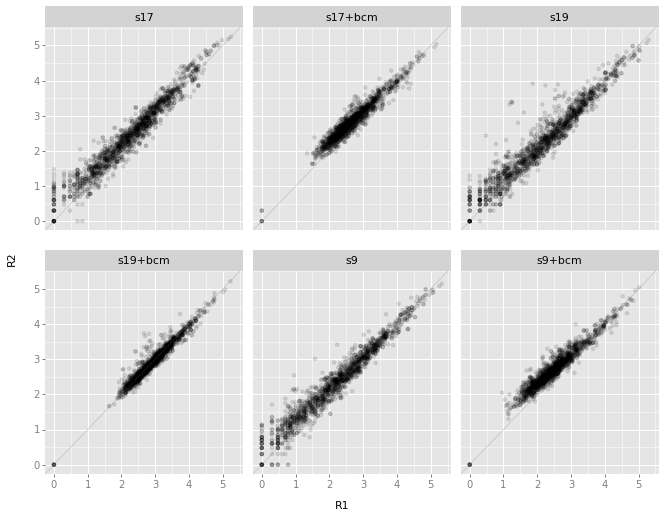

<ggplot: (8783501883256)>


In [73]:
p = ggplot(long, aes(x='R1', y='R2')) \
        + geom_point(size=2.5, alpha=0.1) \
        + geom_abline(slope=1, intercept=0, size=.5, alpha=0.4, color='#586e75') \
        + facet_wrap('sample')
print(p)